<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# Apilando redes recurrentes<a id="top"></a>

<i>Última actualización: 2025-03-03</small></i></div>
***

## Introducción

Las RNN apiladas (del inglés _stacked_) son un tipo de red neuronal formada por múltiples capas de RNN apiladas unas sobre otras. Se ha demostrado que las RNN apiladas mejoran el rendimiento de las RNN en diversas tareas al permitir que la red aprenda representaciones más complejas de datos secuenciales.

En una RNN apilada, la salida de una capa de la RNN se pasa como entrada a la capa siguiente, creando una representación jerárquica de la secuencia.

## Objetivos

En este _notebook_ resolveremos un problema anterior con este tipo de arquitectura, viendo cómo implementar un modelo con varias capas recurrentes superpuestas.

## Bibliotecas y configuración

A continuación importaremos las librerías que se utilizarán a lo largo del cuaderno.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchmetrics
import torchsummary
import torchvision

import utils

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

Por último, establecemos las constantes de los recursos comunes.

In [3]:
DATASETS_DIR = './tmp'
BATCH_SIZE = 1024
TRAIN_EPOCHS = 25

***

## Descarga y preproceso de los datos

Una vez más, utilizaremos el conjunto de datos _fashion_ MNIST porque es mola bastante.

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_set = torchvision.datasets.FashionMNIST(
    root=DATASETS_DIR,
    train=True,
    download=True,
    transform=transform,
)
test_set = torchvision.datasets.FashionMNIST(
    root=DATASETS_DIR,
    train=False,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=BATCH_SIZE, shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False,
)

## Modelo basado en múltiples capas de `RNN`

En una arquitectura multicapa, **cada capa recurrente procesa una secuencia de entradas** y, al configurarlas para que devuelvan la secuencia completa, la siguiente capa también puede recibir una secuencia.

En PyTorch, el comportamiento por defecto de las `RNN` (por ejemplo, `torch.nn.RNN`) es devolver la secuencia completa, es decir, un tensor de forma `(batch_size, sequence_len, num_features)`. Por lo tanto, al apilar capas recurrentes, basta con pasar la salida completa de la primera capa como entrada a la siguiente.

In [5]:
class RNNModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rnn1 = torch.nn.RNN(input_size=28, hidden_size=8, batch_first=True)
        self.rnn2 = torch.nn.RNN(input_size=8, hidden_size=8, batch_first=True)
        self.rnn3 = torch.nn.RNN(input_size=8, hidden_size=8, batch_first=True)
        self.fc = torch.nn.Linear(in_features=8, out_features=10)
        
    def forward(self, x):
        x = x.squeeze(1)
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out, _ = self.rnn3(out)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = RNNModel()
torchsummary.summary(model, input_size=(28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 28, 8], [-1, 2, 8]]               0
               RNN-2  [[-1, 28, 8], [-1, 2, 8]]               0
               RNN-3  [[-1, 28, 8], [-1, 2, 8]]               0
            Linear-4                   [-1, 10]              90
Total params: 90
Trainable params: 90
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


Hay que tener cuidado porque en Keras el comportamiento es el contrario. Las unidades recurrentes devuelven únicamente el último valor, y es necesario usar el parámetro `return_sequences=True` para que el comportamiento sea el de devolver una secuencia con cada una de las inferencias.

### Entrenamiento del modelo

Por último, entrenaremos nuestra red durante $10$ epochs. Sí, si con las redes recurrentes era lento, con las redes apiladas lo es aún más.

In [9]:
history = utils.train(
    model=model,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters()),
    validation_split=0.1,
    metric_fn=torchmetrics.classification.MulticlassAccuracy(num_classes=10),
)

Epoch 1/25 (9.03s), Train loss: 0.9083, Train metric: 0.6622, Val loss: 0.9199, Val. metric: 0.6726
Epoch 2/25 (8.41s), Train loss: 0.8971, Train metric: 0.6651, Val loss: 0.9091, Val. metric: 0.6728
Epoch 3/25 (8.58s), Train loss: 0.8856, Train metric: 0.6684, Val loss: 0.9058, Val. metric: 0.6723
Epoch 4/25 (8.06s), Train loss: 0.8754, Train metric: 0.6722, Val loss: 0.8900, Val. metric: 0.6811
Epoch 5/25 (8.12s), Train loss: 0.8653, Train metric: 0.6757, Val loss: 0.8822, Val. metric: 0.6798
Epoch 6/25 (7.69s), Train loss: 0.8565, Train metric: 0.6782, Val loss: 0.8756, Val. metric: 0.6810
Epoch 7/25 (8.05s), Train loss: 0.8539, Train metric: 0.6782, Val loss: 0.8761, Val. metric: 0.6796
Epoch 8/25 (7.91s), Train loss: 0.8483, Train metric: 0.6807, Val loss: 0.8661, Val. metric: 0.6840
Epoch 9/25 (8.26s), Train loss: 0.8444, Train metric: 0.6808, Val loss: 0.8640, Val. metric: 0.6813
Epoch 10/25 (8.11s), Train loss: 0.8467, Train metric: 0.6787, Val loss: 0.8613, Val. metric: 0.6835

Veamos cómo ha ido el entrenamiento del modelo.

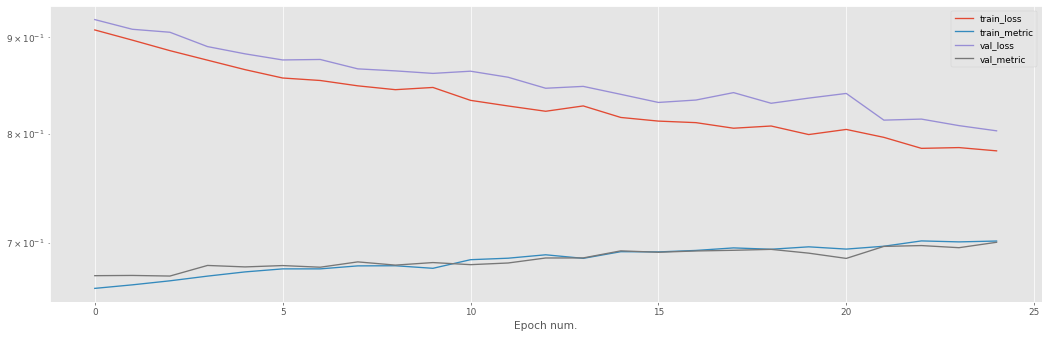

In [10]:
pd.DataFrame(history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

Quizá la precisión con la que ha clasificado sea mejor, pero en este problema concreto, las redes convolucionales siguen siendo la mejor opción.

### Clasificación de nuevas muestras

Ahora imprimiremos algunos de los elementos de la prueba para ver cómo se han clasificado y cuáles han sido los errores.

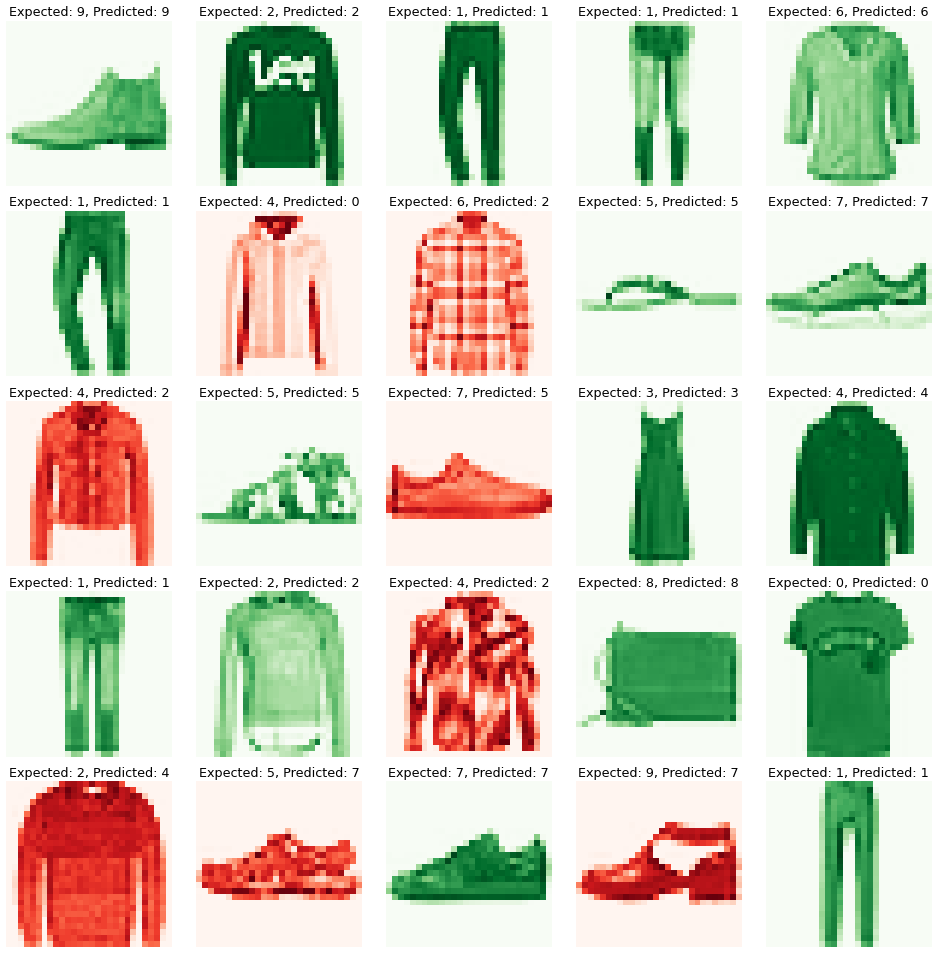

In [11]:
ROWS, COLS = 5, 5
IMAGES = ROWS * COLS

images, labels = [], []
for i in range(IMAGES):
    img, label = test_set[i]
    images.append(img)
    labels.append(label)

images_tensor = torch.stack(images)

model.eval()
with torch.no_grad():
    outputs = model(images_tensor)
    preds = torch.argmax(outputs, dim=1).numpy()

fig = plt.figure(figsize=(15, 15))
for i, (img, true_label, pred_label) in enumerate(zip(images_tensor, labels, preds), 1):
    ax = fig.add_subplot(ROWS, COLS, i)
    img_np = img.squeeze(0).numpy()
    ax.imshow(img_np, cmap='Greens' if true_label == pred_label else 'Reds')
    ax.set_title(f'Expected: {true_label}, Predicted: {pred_label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Conclusiones

Hemos mostrado cómo implementar una red neuronal recurrente apilada en PyTorch, concretamente un modelo RNN de dos capas con $8$ unidades en cada capa. Y aunque lo hemos aplicado al problema _fashion MNIST, hemos comprobado que no es la mejor opción (al menos en tiempo de entrenamiento). Sin embargo, apilar RNN puede ser una técnica muy útil para modelar datos secuenciales, ya que permite al modelo capturar dependencias más complejas entre las entradas y las salidas.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>